In [1]:
import h5py # .h5 파일을 읽기 위한 패키지
import random
import pandas as pd
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore') 
# Convnet, ensenble, smoothing, baysian search

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [3]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':4,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
all_df = pd.read_csv('./open/train.csv')
all_points = h5py.File('./open/train.h5', 'r')

In [6]:
all_df

,ID,label
0,0,5
1,1,0
2,2,4
3,3,1
4,4,9
...,...,...
49995,49995,5
49996,49996,0
49997,49997,8
49998,49998,4


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    all_df, test_size=0.1, stratify=all_df['label'])

([<matplotlib.patches.Wedge at 0x7fc8c691dbd0>,
 [Text(1.0307368909880943, 0.3841633266674446, '0'),
  Text(0.5581003046779709, 0.9479050848678661, '1 '),
  Text(-0.12462273365741199, 1.0929177344410483, '2'),
  Text(-0.7477459988853693, 0.8067688151824669, '3'),
  Text(-1.078552563313653, 0.21615820171704977, '4'),
  Text(-1.0019454504004814, -0.4539882315895165, '5'),
  Text(-0.5507579903505752, -0.9521899159647701, '6'),
  Text(0.09973409431638568, -1.095469356226312, '7'),
  Text(0.708911890328467, -0.8410968622881194, '8'),
  Text(1.0562072961466464, -0.30728837850883767, '9')],
 [Text(0.5622201223571422, 0.20954363272769705, '11.36%'),
  Text(0.3044183480061659, 0.5170391372006542, '10.35%'),
  Text(-0.06797603654040653, 0.5961369460587536, '10.20%'),
  Text(-0.40786145393747414, 0.44005571737225463, '9.98%'),
  Text(-0.5883013981710834, 0.11790447366384532, '9.94%'),
  Text(-0.5465157002184444, -0.2476299445033726, '9.90%'),
  Text(-0.3004134492821319, -0.5193763177989654, '9.86

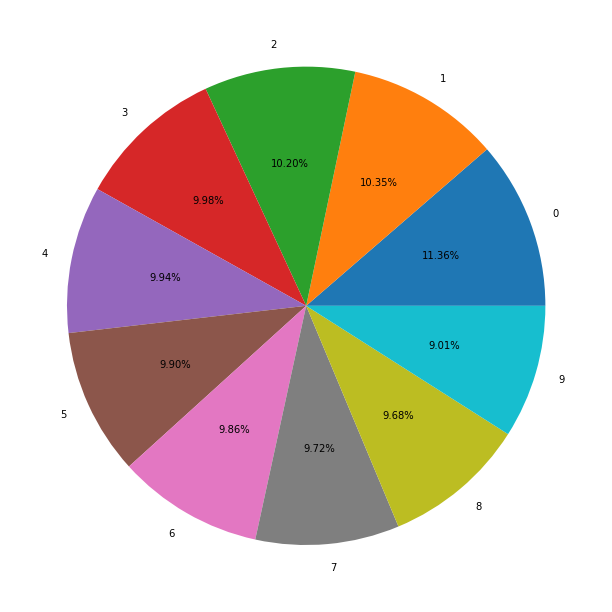

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 11))
label = ['0', '1 ','2','3','4','5','6','7','8','9']
plt.pie(all_df['label'].value_counts(),
        labels=label, autopct='%.2f%%')

In [9]:
print(len(train_df))
print(len(val_df))

45000
5000


## CustomDataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, id_list, label_list, point_list):
        self.id_list = id_list
        self.label_list = label_list
        self.point_list = point_list
        
    def __getitem__(self, index):
        image_id = self.id_list[index]
        
        # h5파일을 바로 접근하여 사용하면 학습 속도가 병목 현상으로 많이 느릴 수 있습니다.
        points = self.point_list[str(image_id)][:]
        image = self.get_vector(points)
        #TODO : transform
        if self.label_list is not None:
            label = self.label_list[index]
            return torch.Tensor(image).unsqueeze(0), label
        else:
            return torch.Tensor(image).unsqueeze(0)
    
    def get_vector(self, points, x_y_z=[200, 200, 200]):
        # 3D Points -> [16,16,16]
        xyzmin = np.min(points, axis=0) - 0.001
        xyzmax = np.max(points, axis=0) + 0.001

        diff = max(xyzmax-xyzmin) - (xyzmax-xyzmin)
        xyzmin = xyzmin - diff / 2
        xyzmax = xyzmax + diff / 2

        segments = []
        shape = []

        for i in range(3):
            # note the +1 in num 
            if type(x_y_z[i]) is not int:
                raise TypeError("x_y_z[{}] must be int".format(i))
            s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
            segments.append(s)
            shape.append(step)

        n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        n_x = x_y_z[0]
        n_y = x_y_z[1]
        n_z = x_y_z[2]

        structure = np.zeros((len(points), 4), dtype=int)
        structure[:,0] = np.searchsorted(segments[0], points[:,0]) - 1
        structure[:,1] = np.searchsorted(segments[1], points[:,1]) - 1
        structure[:,2] = np.searchsorted(segments[2], points[:,2]) - 1

        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * n_x) + structure[:,0]) + (structure[:,2] * (n_x * n_y)) 

        vector = np.zeros(n_voxels)
        count = np.bincount(structure[:,3])
        vector[:len(count)] = count

        vector = vector.reshape(n_z, n_y, n_x)
#         print(vector.shape)
        return vector

    def __len__(self):
        return len(self.id_list)

In [11]:
train_dataset = CustomDataset(train_df['ID'].values, train_df['label'].values, all_points)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df['ID'].values, val_df['label'].values, all_points)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

In [12]:
#https://github.com/shijianjian/EfficientNet-PyTorch-3D
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D


In [13]:
from efficientnet_pytorch_3d import EfficientNet3D
import torch

model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 10}, in_channels=1)


## Train

In [14]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for data, label in tqdm(iter(train_loader)):
            data, label = data.float().to(device), label.long().to(device)
            optimizer.zero_grad()
#             print(data.shape)
            output = model(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss.append(loss.item())
        
        if scheduler is not None:
            scheduler.step()
            
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss)}] Val Loss : [{val_loss}] Val ACC : [{val_acc}]')
        
        if best_score < val_acc:
            best_score = val_acc
            torch.save(model.state_dict(), './'+epoch+'best_model.pth')

In [15]:
def validation(model, criterion, val_loader, device):
    print("val..")
    model.eval()
    true_labels = []
    model_preds = []
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(val_loader)):
            data, label = data.float().to(device), label.long().to(device)
            
            model_pred = model(data)
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
    
    return np.mean(val_loss), accuracy_score(true_labels, model_preds)

## Run!!

In [ ]:
from transformers import get_cosine_schedule_with_warmup

# model = EfficientNet.from_pretrained('efficientnet-b7',num_classes=10)
# model = ef_model
checkpoint = torch.load('./best_model.pth')
model.load_state_dict(checkpoint)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0006,weight_decay=0.0001)
scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = len(train_loader)*3,num_training_steps = len(train_loader)*CFG['EPOCHS'])

train(model, optimizer, train_loader, val_loader, scheduler, device)


  0%|          | 0/11250 [00:00<?, ?it/s]

## Inference

In [11]:
test_df = pd.read_csv('./open/sample_submission.csv')
test_points = h5py.File('./open/test.h5', 'r')

In [18]:

test_dataset = CustomDataset(test_df['ID'].values, None, test_points)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [20]:
checkpoint = torch.load('./best_model.pth')
# model = model()
model.load_state_dict(checkpoint)
model.eval()

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

In [21]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    model_preds = []
    with torch.no_grad():
        for data in tqdm(iter(test_loader)):
            data = data.float().to(device)
            
            batch_pred = model(data)
            
            model_preds += batch_pred.argmax(1).detach().cpu().numpy().tolist()
    
    return model_preds

In [22]:
preds = predict(model, test_loader, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Submit

In [23]:
test_df['label'] = preds
test_df.to_csv('./submit.csv', index=False)